# 1. Data Exploration and Visualization
- Explore the Breast Cancer Dataset.
- Provide visualizations such as histograms, scatter plots, or box plots to understand the distribution of different features.
- Include any other plots you find interesting and provide brief interpretations.

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# original dataset
cancer_df = pd.read_csv("cancer.csv")
# remove any Unnamed columns from dataset
cancer_df = cancer_df.loc[:, ~cancer_df.columns.str.contains('^Unnamed')]
# no missing values found
missing_values = cancer_df.isnull().sum()
# encoding diagnosis column
cancer_df['diagnosis'] = cancer_df['diagnosis'].map({'M': 1, 'B': 0})

# drop column 'id' as irrelevant
cancer_df.drop(columns=['id'], inplace=True)

# drop NA if any
cancer_df = cancer_df.dropna()

# Display the summary of the data
print(cancer_df.describe(include='all'))


        diagnosis  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  569.000000   569.000000    569.000000      569.000000   569.000000   
mean     0.372583    14.127292     19.289649       91.969033   654.889104   
std      0.483918     3.524049      4.301036       24.298981   351.914129   
min      0.000000     6.981000      9.710000       43.790000   143.500000   
25%      0.000000    11.700000     16.170000       75.170000   420.300000   
50%      0.000000    13.370000     18.840000       86.240000   551.100000   
75%      1.000000    15.780000     21.800000      104.100000   782.700000   
max      1.000000    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720       

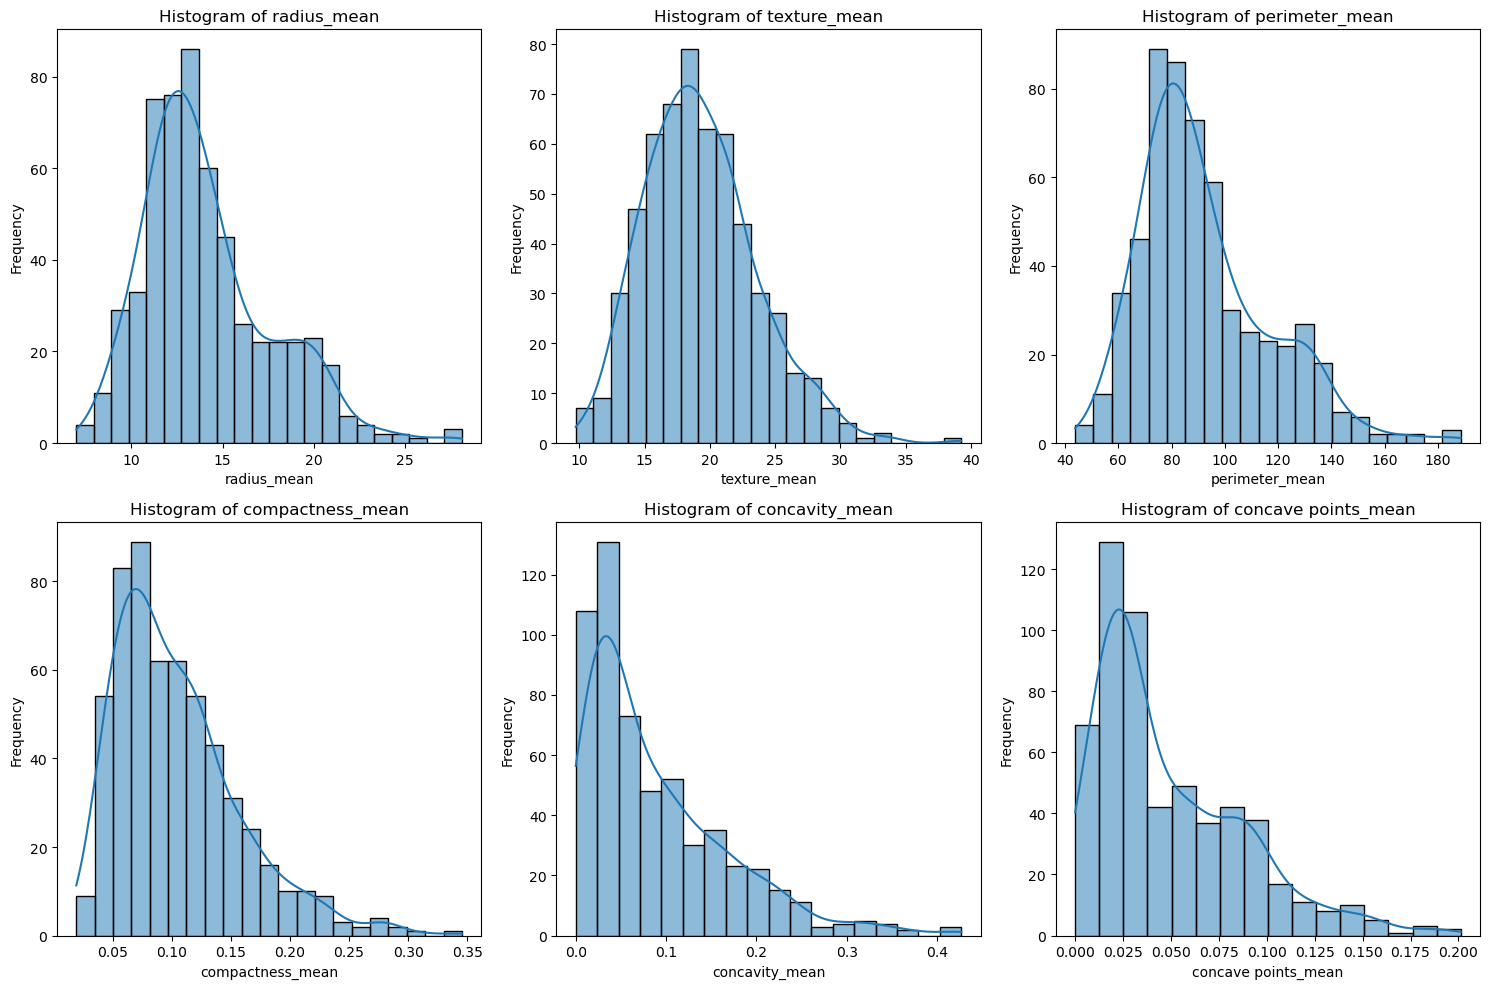

In [3]:
# select a few mean columns to visualize
selected_columns = ['radius_mean', 'texture_mean', 'perimeter_mean', 'compactness_mean', 'concavity_mean', 
                    'concave points_mean' ]

# plotting histograms for these columns
plt.figure(figsize=(15, 10))
for i, column in enumerate(selected_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(cancer_df[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

All of these features appear to have a relatively right-skewed distribution, which indicates that most cancer have a smaller means of radius, texture, perimeter, compactness, concavity, and concave points. Below I will be using box plots for examining outliers. 

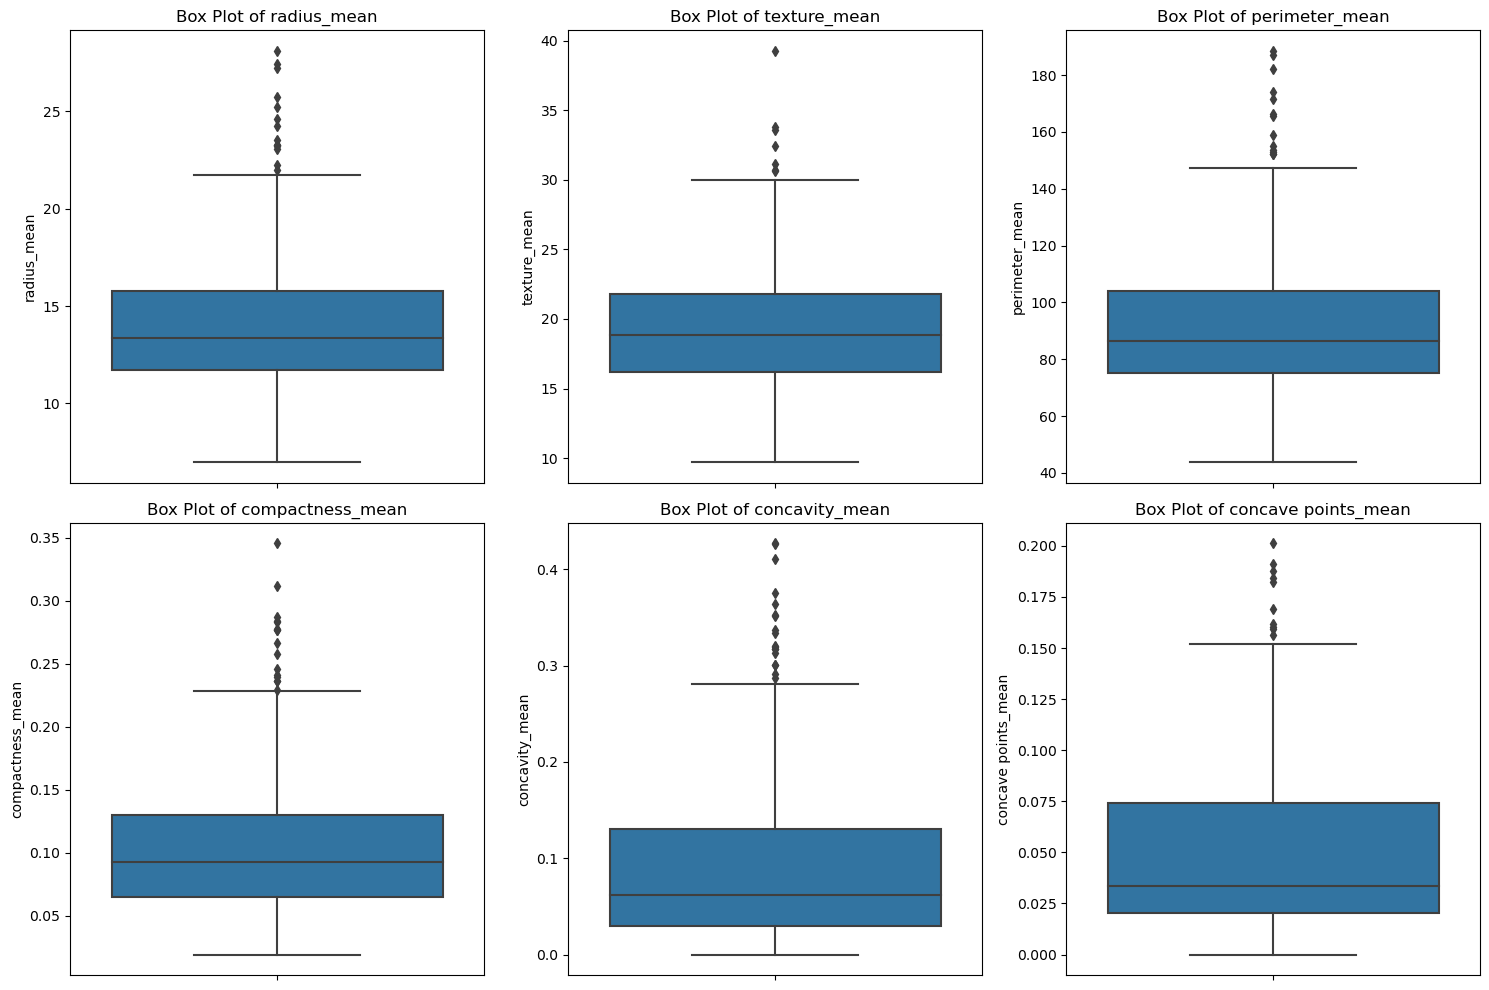

In [4]:
# Plotting box plots for the same attributes above
plt.figure(figsize=(15, 10))
for i, column in enumerate(selected_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=cancer_df[column])
    plt.title(f'Box Plot of {column}')

plt.tight_layout()
plt.show()

These box plots shows that each of these attributes have some outliers on the higher end, which indicates that there are some cancers with relatively larger of means of radius, texture, perimeter, compactness, and concavity, and concave points. 

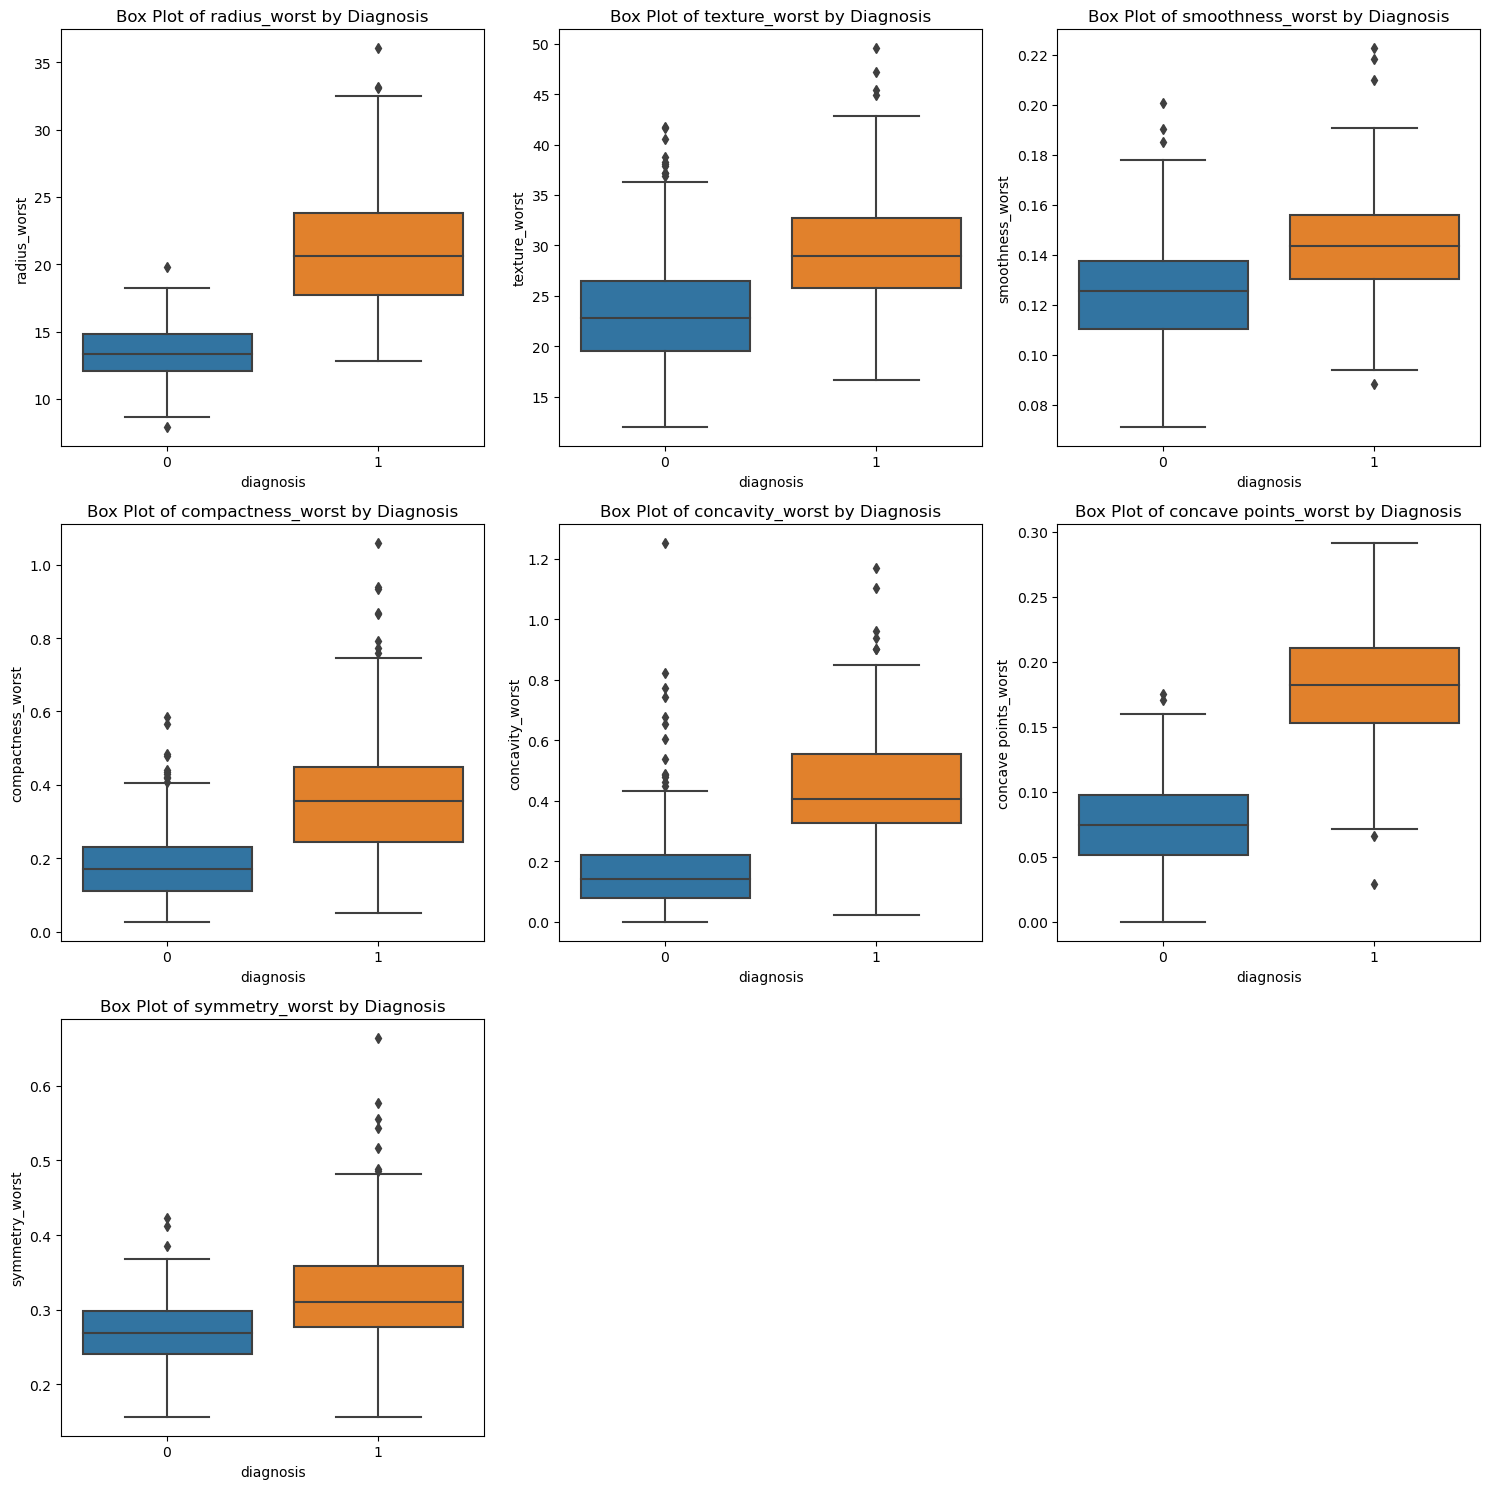

In [5]:
# Select a few 'worst' columns for visualization vs diagnosis
selected_columns_worst = ['radius_worst', 'texture_worst', 'smoothness_worst', 
                          'compactness_worst', 'concavity_worst', 'concave points_worst', 
                          'symmetry_worst']

# Plotting box plots for each of these
plt.figure(figsize=(15, 15))  # Adjusted the figure size to better fit the number of plots
for i, column in enumerate(selected_columns_worst, 1):
    plt.subplot(3, 3, i)  # Adjusted the grid dimensions to 3x3 for 7 plots
    sns.boxplot(x='diagnosis', y=column, data=cancer_df)  
    plt.title(f'Box Plot of {column} by Diagnosis')

plt.tight_layout()
plt.show()


The above plots clearly shows that these "worst" attributes have important relationship with diagnosis. They indicate that malignant cancers have larger worst values of these attributes.

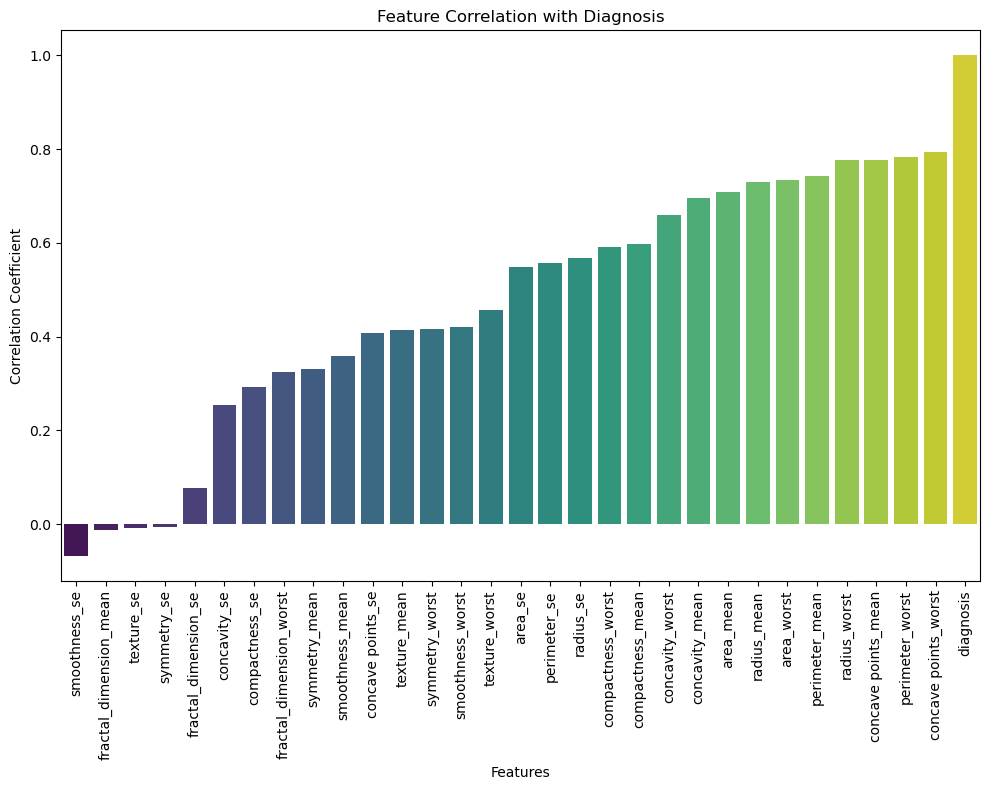

In [6]:
# Calculate correlation with diagnosis
correlation_with_target = cancer_df.corr()['diagnosis'].sort_values()

# Create a bar chart
plt.figure(figsize=(10, 8))
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette="viridis")
plt.xticks(rotation=90)  # Rotate x labels for readability
plt.title('Feature Correlation with Diagnosis')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.tight_layout()  
plt.show()

The bar chart above shows the correlations of all the variables with diagnosis (benign or malignant). A lot of the "mean" and "worst" attributes have the highest positive correlation with diagnosis, such as concave points-worst, perimeter-worst, radius-mean, perimeter- mean. There are some "se" attributes have moderate correlationn with diagnosis as well, such as radius-se, perimeter-se, area-se. There are also some attributes that have close to 0 correlation with diagnosis, including smoothness-se, fractal-dimension-mean, texture-se, symmetry-se. These observations can be very useful to identify which variables should be selected in the predictive models. 

# 2. Logistic Regression Model Development
- Develop a logistic regression model to predict whether cancer is malignant or benign.
- Preprocess the data as necessary (handling missing values, encoding categorical variables, etc.).
- Explain the steps you took in preparing the data and developing the model.
- You might need to encode the values for your prediction.


# Explanation: 

On Q1, I've remove the unamed columns from the dataset. There was also no missing values found. I've encoded the diagnosis column as M = 1 and B = 0. I've also dropped the column of 'id' as its irrelevant of modeling. 

For below model building, I will be choosing 70/30 split for tain/test. The whole dataset has 569 rows, which i think is relatively small for a marchine learning. I think 70/30 can ensuare that the model has enough data for training but also large enough for testing. 

I will be utilizing forward stepwise function the select the features to be included in my logistic model. I am using this method here because after trying to fit every single variables in the dataset to the logistic model, I got negative R^2 and the all p-values were not significant. I realized that it could be due to overfitting, perfect seperation, etc. As as result, I am using one of the popular methods of feature selections - forward stepwise to select the features. I also keep in mind that this method has its drawbacks as well, so the model needs to be evaluated, which i will be doing below as well. 

In [7]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

cancer_df.columns = cancer_df.columns.str.replace(' ', '_')

# Below creating a forward stepwise function
def forward_selection(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response, ' + '.join(selected + [candidate]))
            score = sm.formula.glm(formula, data, family=sm.families.Binomial()).fit().aic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    return selected  # Return the list of selected feature names

X = cancer_df.drop(['diagnosis'], axis=1) 
y = cancer_df['diagnosis']

selected_features = forward_selection(cancer_df, 'diagnosis')

# Prepare the dataset with the selected features
X_selected = sm.add_constant(cancer_df[selected_features])
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.30, random_state=500)

# Standardize the features so that there is no scaling issues
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Make predictions
# classification
y_pred = model.predict(X_test_scaled)
# probabilities of positive class
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
# compare test class lables and predicted class labels
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

(accuracy, conf_matrix)

(0.9883040935672515,
 array([[113,   2],
        [  0,  56]], dtype=int64))

Above I got the accuracy ratio of 98.8% which indicates that the model built is highly accurate on the test dataset, and this is a good sign of my model's prediction. The confusion matrix above shows that out of 171 cases, the model prediced benigh correctly 113 times (true negative) and maliagnent correctly 56 times(True Positive). And only predicted maliagnent where there was no cancer(false positives) in 2 cases and there was 0 cases found where the model predicted benigh when there was cancer (false negatives). 

In medical industry, it is much worse to have false negatives than to have false positives. Considering the false negatives(when predicted no cancer when actually there is) is 0 in this case, this is a good outcome in my model. 

Overall, the high accuracy ratio is a good sign for my model, though the high accuracy here could indicate that there is overfitting. I will be further evaluating it below. 

# 3. Model Evaluation
- Evaluate your logistic regression model using appropriate metrics (e.g., accuracy, R^2, RMSE (all out-of-sample)).
- Split the dataset into training and testing sets to perform this evaluation.
- Interpret these metrics to assess the performance of your model. Is it good? Why?

# Explanation: 

On question 2, I've already splitted the data into training and testing sets 70/30, and calculated the accuracy ratio and confution matrics. Below I will be using more metrics to evaluate the model. 

In [8]:
import numpy as np
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, log_loss


# Fit the GLM model (full model using the training dataset)
full_model = sm.GLM(y, cancer_df[selected_features], family=sm.families.Binomial()).fit()

# Function to calculate McFadden's R-squared
def mcfadden_r2(y_true, y_pred_prob):
    null_model_pred = np.full_like(y_true, y_true.mean())
    null_ll = -np.mean(y_true * np.log(null_model_pred) + (1 - y_true) * np.log(1 - null_model_pred))
    model_ll = -np.mean(y_true * np.log(y_pred_prob) + (1 - y_true) * np.log(1 - y_pred_prob))
    return 1 - (model_ll / null_ll)

mcfadden_r_squared = mcfadden_r2(y_test, y_pred_prob)
print(f"McFadden's R^2: {mcfadden_r_squared:.6f}")

McFadden's R^2: 1.000000


C:\Users\szhou\AppData\Local\Temp\ipykernel_33284\453406036.py:16: RuntimeWarning: divide by zero encountered in log
  null_ll = -np.mean(y_true * np.log(null_model_pred) + (1 - y_true) * np.log(1 - null_model_pred))
C:\Users\szhou\AppData\Local\Temp\ipykernel_33284\453406036.py:17: RuntimeWarning: divide by zero encountered in log
  model_ll = -np.mean(y_true * np.log(y_pred_prob) + (1 - y_true) * np.log(1 - y_pred_prob))


In [9]:
from sklearn.metrics import mean_squared_error, roc_auc_score, precision_score, recall_score, f1_score, classification_report, log_loss


# Check if the lengths of y_test and y_pred_prob match
if len(y_test) == len(y_pred_prob):

    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_prob))
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    # Calculate Precision, Recall, and F1 Score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Classification Report
    class_report = classification_report(y_test, y_pred)
    # Calculate Log Loss
    logloss = log_loss(y_test, y_pred_prob)

    # Compile the evaluation metrics into a dictionary
    evaluation_metrics = {
        'out of sample evaluation': {
            'RMSE': rmse_test,
            'ROC AUC': roc_auc,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        }
    }

    # Displaying results
    print("Evaluation:\n", evaluation_metrics)
    print("\nClassification Report:\n", class_report)
    print(f"\nLog Loss: {logloss}")
else:
    print("mismatch")



Evaluation:
 {'out of sample evaluation': {'RMSE': 0.08829689852109639, 'ROC AUC': 1.0, 'Precision': 0.9655172413793104, 'Recall': 1.0, 'F1 Score': 0.9824561403508771}}

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       115
           1       0.97      1.00      0.98        56

    accuracy                           0.99       171
   macro avg       0.98      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171


Log Loss: 0.03953153311124715


Based on the discussion above for the accuracy ratio and confusion matrix(in question 2), it indicates that the prediction model fits really well with the training dataset. 

I chose to calculate pseudo R^2 to validate the model as it works better with logistic regression model, and a true R^2 calculation can not be defined in this case. The pseudo R^2 (McFadden's R^2) value of 1.00 indicates that the model explains 100% of the variability in the diagnosis, this is a perfect value that suggests the model fits the data really well.

RMSE tells me how wide the data spread out, the lower RMSE the better. The RMSE here is 0.088, which suggests that on average, the predicted probabilities of the positive class are close to the true value. 

The ROC AUC of 1.0 is a perfect score, this tells me that the model is helping to perfectly distinguish beteen positive and negative classes. 

The precision for positive class is 96.55% which means that the instances where it was predicted positive are in fact positive. And Recall for positive class is 1 which indicates that the model perfectly identified all actual positives in the test dataset. The F1 score of 0.9825 indicates a good balance of precision and recall. 

Similar to above, the classification report also indicate the excellence of the model. 

log loss of 0.0395 indicates that the model has a good performance. 

Overall the model shows really good predicton on the test dataset. I will be further perfoming evaluation through cross-validation on question 5. 

 # 4. Testing Interactions Between Features
- Explore and test the interactions between different features in the dataset. Pay particular attention to interactions involving both categorical/dummy and continuous variables.
- For this excercise, use a linear regression rather than a logistic regression model.
- Discuss issues that occur when using a linear regression model to predict binary outcomes.
- Create and analyze interaction terms involving categorical/dummy variables (such as 'diagnosis' converted into a dummy variable) and continuous variables (like 'radius_mean' or 'texture_mean').
- Fit a regression model that includes interaction terms, for example, between 'diagnosis' and 'radius_mean', and between 'diagnosis' and 'texture_mean'.
- Discuss the influence of these interactions on the model. Describe how to interpret these interactions and their implications for understanding the data.

In [10]:
cancer_with_interactions = cancer_df
cancer_with_interactions

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.formula.api as smf

# Add interaction terms
cancer_with_interactions['diagnosis_radius_interaction'] = cancer_with_interactions['diagnosis'] * cancer_with_interactions['radius_mean']
cancer_with_interactions['diagnosis_texture_interaction'] = cancer_with_interactions['diagnosis'] * cancer_with_interactions['texture_mean']

formula = 'diagnosis ~ radius_mean + texture_mean + diagnosis_radius_interaction + diagnosis_texture_interaction'
# Fit the regression model
interaction_model = smf.ols(formula, data=cancer_with_interactions).fit()

# Output the summary of the model to see the influence of the interaction terms
interaction_model_summary = interaction_model.summary()
interaction_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              diagnosis   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     8648.
Date:                Thu, 25 Jan 2024   Prob (F-statistic):               0.00
Time:                        23:35:05   Log-Likelihood:                 781.81
No. Observations:                 569   AIC:                            -1554.
Df Residuals:                     564   BIC:                            -1532.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.4197      0.021     20.196      0.000       0.379       0.460
radius_mean                      -0.0236      0.002    -15.294      0.000      -0.027      -0.021
texture_mean                     -0.0071      0.001     -9.371      0.000      -0.009      -0.006
diagnosis_radius_interaction      0.0390      0.002     25.057      0.000       0.036       0.042
diagnosis_texture_interaction     0.0210      0.001     19.573      0.000       0.019       0.023
==============================================================================
Omnibus:                        6.084   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                7.147
Skew:                          -0.132   Prob(JB):                       0.0281
Kurtosis:                       3.482   Cond. No.                         224.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# Using all the features in the dataset + interaction terms created above to build below model
X = cancer_with_interactions[['radius_mean', 'texture_mean', 'diagnosis_radius_interaction', 'diagnosis_texture_interaction']]
y = cancer_with_interactions['diagnosis']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=500)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the performance metrics
(mse, r2)

from sklearn.metrics import accuracy_score, confusion_matrix

# Since we're using a linear regression model, the predictions will be continuous.
# We need to decide on a threshold to convert them to binary for calculating accuracy and the confusion matrix.
# A common threshold is 0.5 for binary outcomes.

# Convert predictions to binary using 0.5 as the threshold
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

(accuracy, conf_matrix)

(1.0,
 array([[115,   0],
        [  0,  56]], dtype=int64))

The R^2 of 0.984, indicating that 98.4% of the variance in diagnosis is explained by the model with interations. This is a high R^2 value. The coefficient for both radius_mean and texture_mean are negative, indicating that as these variables increase, the probability of being positive class decreases. However, the interaction terms both have positive coefficients, meaning these two varaiables acts differently depending on diagnosis. The p-values though, seems quite strange here, as all of them are 0. 

The accuracy ratio and confusion matrix also seems pretty perfect. There are no cases of false negatives or false positives. This is quite suspicious as well.

My understanding is using linear regression for a binary problem is not quite standard, as linear regression is continuous and predictions can have all the possibilities. Logistic regression should be more proper for a binary context as it ensures predictions falls between 0 to 1. Also the threshold of 0.5 could also be the reason of this result as different thresholds could cause very different results, and without further investigation in the field, its hard to choose an very appropriate threshold. 

# 5. Feature Selection and Cross-Validation: Full vs. Reduced Model
- Create a reduced model using only a subset of significant predictors. You can use methods like FDR Cutoff, forward selection, backward elimination, or any other appropriate feature selection technique.
- Compare the performance of the full model (using all predictors) with the reduced model (using significant predictors) using 10-fold cross-validation.
- Evaluate the out-of-sample performance for both models across folds and discuss which model performs better and why.

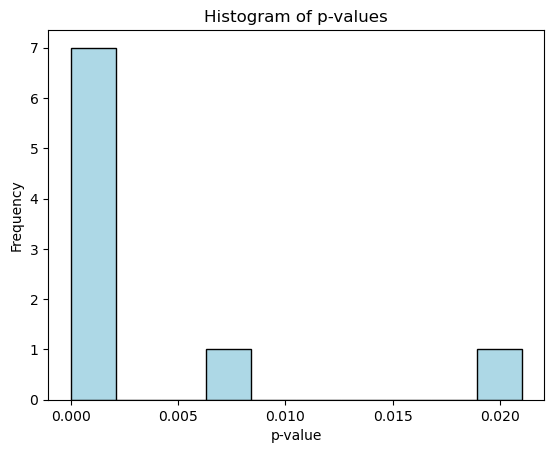

In [13]:
# Get the p-values (excluding the constant)
p_values = full_model.pvalues[1:]

# Plot the histogram of p-values
plt.hist(p_values, color="lightblue", edgecolor="black")
plt.xlabel("p-value")
plt.ylabel("Frequency")
plt.title("Histogram of p-values")
plt.show()

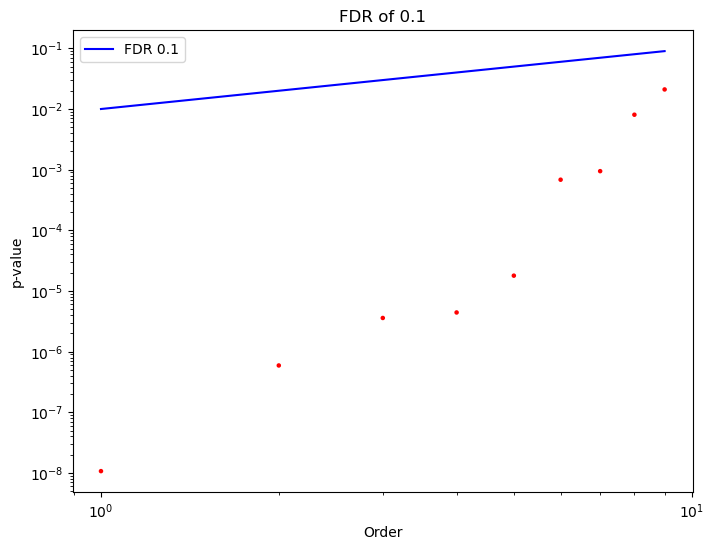

Threshold p-value at 10% FDR: 0.0210


In [14]:
def fdr_cut(pvals, q=0.1):
    """
    Determine the threshold p-value at a given FDR level and plot the p-values.

    Parameters:
        pvals (list or array): A list or array of p-values.
        q (float): The desired FDR level.

    Returns:
        float: The threshold p-value at the given FDR level.
    """
    # Sort p-values and remove NaNs
    pvals = sorted([p for p in pvals if not pd.isna(p)])
    N = len(pvals)
    k = np.arange(1, N + 1)
    alpha = max(p for p, rank in zip(pvals, k) if p <= q * rank / (N + 1))

    # Plot the p-values
    plt.figure(figsize=(8, 6))
    plt.scatter(k, pvals, c=['gray' if p > alpha else 'red' for p in pvals], s=5)
    plt.plot(k, q * k / (N + 1), color='blue', label=f'FDR {q}')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Order")
    plt.ylabel("p-value")
    plt.title(f"FDR of {q}")
    plt.legend()
    plt.show()

    return alpha

# Apply the function on the extracted p-values
threshold = fdr_cut(p_values)
print(f"Threshold p-value at 10% FDR: {threshold:.4f}")


In [15]:
# Identify significant predictors based on the threshold p-value
significant_predictors = p_values[p_values <= threshold].index.tolist()
# Include the dependent variable 'diagnosis' in the selected columns
selected_columns = ['diagnosis'] + significant_predictors

# Prepare the data for the new model
X_cut = cancer_df[selected_columns].drop('diagnosis', axis=1)
X_cut = sm.add_constant(X_cut)  # Add a constant (intercept) to the predictors
y_cut = cancer_df['diagnosis']

# Fit the new GLM model using only the significant predictors
cut_model = sm.GLM(y_cut, X_cut, family=sm.families.Binomial()).fit()

# Calculate the R^2 value for the new model
r_squared_cut = 1 - (cut_model.deviance / cut_model.null_deviance)

print(f"R^2 value for the new/cut model: {r_squared_cut:.4f}")
4

R^2 value for the new/cut model: 0.9254


4

In [16]:
cancer_df[selected_features]

,perimeter_worst,smoothness_worst,texture_worst,radius_se,symmetry_worst,compactness_se,concavity_mean,texture_se,area_se,concave_points_worst
0,184.60,0.16220,17.33,1.0950,0.4601,0.04904,0.30010,0.9053,153.40,0.2654
1,158.80,0.12380,23.41,0.5435,0.2750,0.01308,0.08690,0.7339,74.08,0.1860
2,152.50,0.14440,25.53,0.7456,0.3613,0.04006,0.19740,0.7869,94.03,0.2430
3,98.87,0.20980,26.50,0.4956,0.6638,0.07458,0.24140,1.1560,27.23,0.2575
4,152.20,0.13740,16.67,0.7572,0.2364,0.02461,0.19800,0.7813,94.44,0.1625
...,...,...,...,...,...,...,...,...,...,...
564,166.10,0.14100,26.40,1.1760,0.2060,0.02891,0.24390,1.2560,158.70,0.2216
565,155.00,0.11660,38.25,0.7655,0.2572,0.02423,0.14400,2.4630,99.04,0.1628
566,126.70,0.11390,34.12,0.4564,0.2218,0.03731,0.09251,1.0750,48.55,0.1418
567,184.60,0.16500,39.42,0.7260,0.4087,0.06158,0.35140,1.5950,86.22,0.2650


In [17]:
cancer_df[significant_predictors]

,smoothness_worst,texture_worst,radius_se,symmetry_worst,compactness_se,concavity_mean,texture_se,area_se,concave_points_worst
0,0.16220,17.33,1.0950,0.4601,0.04904,0.30010,0.9053,153.40,0.2654
1,0.12380,23.41,0.5435,0.2750,0.01308,0.08690,0.7339,74.08,0.1860
2,0.14440,25.53,0.7456,0.3613,0.04006,0.19740,0.7869,94.03,0.2430
3,0.20980,26.50,0.4956,0.6638,0.07458,0.24140,1.1560,27.23,0.2575
4,0.13740,16.67,0.7572,0.2364,0.02461,0.19800,0.7813,94.44,0.1625
...,...,...,...,...,...,...,...,...,...
564,0.14100,26.40,1.1760,0.2060,0.02891,0.24390,1.2560,158.70,0.2216
565,0.11660,38.25,0.7655,0.2572,0.02423,0.14400,2.4630,99.04,0.1628
566,0.11390,34.12,0.4564,0.2218,0.03731,0.09251,1.0750,48.55,0.1418
567,0.16500,39.42,0.7260,0.4087,0.06158,0.35140,1.5950,86.22,0.2650


On Question 2, I used forward stepwise selection to select the features in my "full model", which includes 10 features. And on the right above, after using FDR control technique, the "cut model" ends up with 9 features. The R^2 I canculated above for cut model is 0.9254, which could be less meaningful in logistic regression, especially for using it to compare with the full model. Below I will be using k fold cross validation to compare the 2 models. 

# Out of sampe prediction

In [18]:
# Define the number of folds for k-fold cross-validation
from sklearn.model_selection import KFold
K = 10

# Define a function for pseudo R-squared (McFadden's R-squared)
def pseudo_r_squared(model, y, predictions):
    p_positive = y.mean()
    L0 = np.sum(y * np.log(p_positive) + (1 - y) * np.log(1 - p_positive))
    L1 = np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return 1 - (L1 / L0)

signif_names = significant_predictors

# Empty lists to store results
OOS_full = []
OOS_cut = []

# Initialize KFold
kf = KFold(n_splits=K, shuffle=True, random_state=42)

# Iterate over each fold
for train_index, test_index in kf.split(cancer_df):
    # Full model
    X_full_train = sm.add_constant(cancer_df[selected_features].iloc[train_index]).reset_index(drop=True)
    y_train = y.iloc[train_index].reset_index(drop=True)
    rfull = sm.GLM(y_train, X_full_train, family=sm.families.Binomial()).fit()

    # Cut model
    # Make sure to drop the 'diagnosis' column from the predictors
    X_cut_train = sm.add_constant(cancer_df[significant_predictors].iloc[train_index]).reset_index(drop=True)
    rcut = sm.GLM(y_train, X_cut_train, family=sm.families.Binomial()).fit()

    # Predictions for the full model
    X_full_test = sm.add_constant(cancer_df[selected_features].iloc[test_index]).reset_index(drop=True)
    pred_full = rfull.predict(X_full_test)
    
    # Predictions for the cut model
    X_cut_test = sm.add_constant(cancer_df[significant_predictors].iloc[test_index]).reset_index(drop=True)
    pred_cut = rcut.predict(X_cut_test)

    # Calculate pseudo R-squared and store
    y_test = cancer_df['diagnosis'].iloc[test_index].reset_index(drop=True)
    OOS_full.append(pseudo_r_squared(rfull, y_test, pred_full))
    OOS_cut.append(pseudo_r_squared(rcut, y_test, pred_cut))

C:\Users\szhou\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\szhou\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\szhou\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\szhou\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\szhou\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\szhou\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in l

In [19]:
OOS_full

[0.8800885891061315,
 0.951229973495113,
 0.9629784399166409,
 0.9514305852641325,
 0.7878433114946599,
 0.38670633824928,
 0.9875844734733716,
 0.9547505042474929,
 0.733025140844507,
 0.9137524032911725]

In [20]:
OOS_cut

[0.8696287017058842,
 0.9529052539481865,
 0.9546727167477232,
 0.9619328280260125,
 0.7862356121726704,
 0.36796090151643013,
 0.9899420558150741,
 0.9624540786892231,
 0.8418415786312027,
 0.9049406028885515]

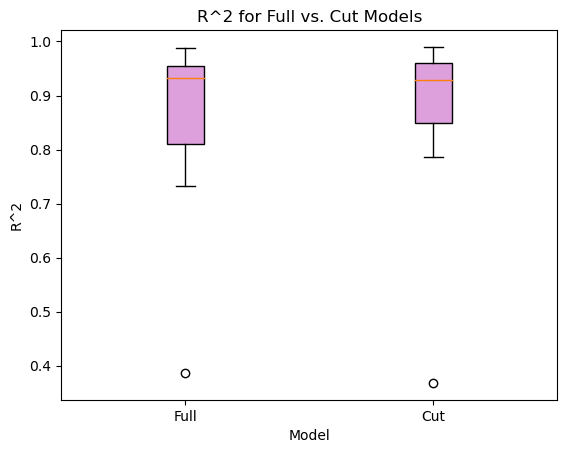

In [21]:
# Cleaning OOS_full
# OOS_full_cleaned = [value for value in OOS_full if not np.isinf(value) and not np.isnan(value)]
# OOS_cut_cleaned = [value for value in OOS_cut if not np.isinf(value) and not np.isnan(value)]

plt.boxplot([OOS_full, OOS_cut], labels=['Full', 'Cut'], patch_artist=True, boxprops=dict(facecolor="plum"))
plt.ylabel('R^2')
plt.xlabel('Model')
plt.title('R^2 for Full vs. Cut Models')
plt.show()

In [22]:
import time

# Calculate average OOS R^2 values
avg_OOS_full = np.mean(OOS_full)
avg_OOS_cut = np.mean(OOS_cut)
print("Average OOS R^2 for Full Model:", avg_OOS_full)
print("Average OOS R^2 for Cut Model:", avg_OOS_cut)

Average OOS R^2 for Full Model: 0.8509389759382502
Average OOS R^2 for Cut Model: 0.8592514330140959


On the above code, I performed a k-fold cross-validation to compare the out-of-sample performance of the full model which I built in question 2 and the cut model which includes only the significant predictors based on the FDR control performed above. The above R^2 calculation is pseudo R^2 which works with logistic regression. 

The average OOS pseudo R^2 for the full model is approximately 0.851, and for the cut model its approximately 0.86. The box plot above shows the distribution of the OOS pseudo R^2 for both model, which appears that the cut model have a relatively smaller range of it, which means the cut model is more consistent and stable with its performance across different folds. The cut model, on average, performed slightly bettern than the full model in terms of the average OOS pseudo R^2, this could be that the FDR control performed retained more significant perdictors. Overall, this indicates that the cut model is the slightly better one that its simpler(contained less predictors) and performance is slightly more stable. I will be calculating AIC and BIC to further compare them. 

In [23]:
AIC_full = []
BIC_full = []
AIC_cut = []
BIC_cut = []

for train_index, test_index in kf.split(cancer_df):
    # Full model
    X_full_train = sm.add_constant(cancer_df[selected_features].iloc[train_index]).reset_index(drop=True)
    y_train = y.iloc[train_index].reset_index(drop=True)
    rfull = sm.GLM(y_train, X_full_train, family=sm.families.Binomial()).fit()

    # Cut model
    X_cut_train = sm.add_constant(cancer_df[significant_predictors].iloc[train_index]).reset_index(drop=True)
    rcut = sm.GLM(y_train, X_cut_train, family=sm.families.Binomial()).fit()

    # AIC and BIC for full model
    AIC_full.append(rfull.aic)
    BIC_full.append(rfull.bic)

    # AIC and BIC for cut model
    AIC_cut.append(rcut.aic)
    BIC_cut.append(rcut.bic)

# average AIC and BIC values
avg_AIC_full = np.mean(AIC_full)
avg_BIC_full = np.mean(BIC_full)
avg_AIC_cut = np.mean(AIC_cut)
avg_BIC_cut = np.mean(BIC_cut)

print("Average AIC for Full Model:", avg_AIC_full)
print("Average BIC for Full Model:", avg_BIC_full)
print("Average AIC for Cut Model:", avg_AIC_cut)
print("Average BIC for Cut Model:", avg_BIC_cut)

Average AIC for Full Model: 69.62947634409727
Average BIC for Full Model: -3078.4929445137896
Average AIC for Cut Model: 68.95079665215003
Average BIC for Cut Model: -3083.4101439527894


C:\Users\szhou\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
C:\Users\szhou\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this

Both AIC and BIC are a little bit lower for the cut model than the full model, which both suggest that the cut model is a more preferred model as it balances modle fit and complexity better than the ful model, and the cut model is more likely containing the significant predictosrs in the data with less chance of overfitting. 